# Course 2: Sensor Fusion
## Part 2: Multi-Target Tracking with Extended Kalman Filter
#### By Jonathan L. Moran (jonathan.moran107@gmail.com)
From the Self-Driving Car Engineer Nanodegree programme offered at Udacity.

## Objectives

* Consider the Kalman filter equations in the 1- and 2-D case;
* Explore linear versus non-linear functions and transformations on Gaussian distributions;
* Perform function approximation using a first-order Taylor expansion to linearise the camera measurement model; 
* Implement the 1-D and 2-D Kalman filter to track objects with LiDAR data;
* Implement the linearised camera measurement model for use with the Extended Kalman Filter (EKF).

## 1. Introduction

In [1]:
### Importing required modules

In [2]:
from IPython.display import YouTubeVideo
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from typing import Tuple
import warnings

In [3]:
!python --version

In [4]:
### Setting environment variables and parameters

In [5]:
ENV_COLAB = False               # True if running in Google Colab instance

In [6]:
# Root directory
DIR_BASE = '' if not ENV_COLAB else '/content/2-Sensor-Fusion'
DIR_BASE = os.path.abspath(DIR_BASE)
DIR_BASE

'/Users/jonathanmoran/Development/ND0013-Self-Driving-Car-Engineer/2-Sensor-Fusion/Exercises'

### 1.1. Sensor Fusion

In this lesson we will be combining our knowledge of computer vision and LiDAR knowledge into one sensor fusion module.

#### Background

_Sensor fusion is a core component of every self-driving car; it is not possible to rely on single sensor alone because every sensor has a unique set of strengths and weaknesses that may fail at times. Therefore, it is crucial for a self-driving car engineer to know how to build a sensor fusion system._

_In the previous lesson of the Sensor Fusion course, you have learned from roboticist and AI researcher Sebastian Thrun the basics of Kalman filters and how they are essential to the Google Self-Driving Car. Sebastian has taught you how to integrate sequential measurements from a single sensor, but actually it is also possible to use Kalman filters to combine measurements from different sensor types._

_In this lesson, you will learn to build a fusion system by using Kalman filters. After the lesson, you will be prepared to fuse LiDAR and camera measures to track vehicles over time in the final project of this course. Does that sound fun?_

_Let's get started!_

⸺ Professor Dr. Antje Muntzinger, self-driving car engineer and technical lead for sensor fusion at Mercedes-Benz.

#### Extended Kalman Filter in 1- and 2-D

In order to track objects over time, we will be building an [Extended Kalman Filter](https://en.wikipedia.org/wiki/Extended_Kalman_filter) (EKF) — here _extended_ denotes a non-linear variant of the standard [Kalman filter](https://en.wikipedia.org/wiki/Kalman_filter) [1] which is able to handle more complex motion and measurement models.

Both Kalman filter algorithms implement two core steps: the _predict_ and the _update_ steps. These two steps are fundamental in using measurements of a vehicle's position to accurately predict where that object will be over time. In the prediction step, we predict the state and the covariance of the tracked object to the time-step of the next measurement. From the previous measurements we have an estimate of position and velocity. Therefore we can predict the new position and new velocity at the next time-step. The _update_ step depends on the sensor type — if the current measurement is generated by a LiDAR sensor, we can simply apply a standard 1-D or 2-D Extended Kalman Filter (EKF) to update the vehicle state. However, camera measurements involve a non-linear measurement function. Therefore, when we receive a camera measurement, we will use a linearisation method to handle this non-linearity.

After transforming to sensor coordinates, we will update our track state. In other words, we will correct our prediction based on the measurement. This loop is repeated over and over, and — when we receive a new measurement — we will predict our state to the next time-step. Then, we will correct our prediction with a new measurement and so on.

In summary, the Kalman filter algorithm will iterate over the following steps to track an object over time:
1. First measurement: the filter will receive initial measurements of the object's position relative to the ego-vehicle. These measurements will come from either a camera or LiDAR sensor;
2. Initialise the state and covariance matrices: the filter will set the object's position $p = \left[p_{x}, p_{y}\right]^{\top}$ and the velocity $v = \left[v_{x}, v_{y}\right]^{\top}$ based on the initial measurement;
3. Run the filtering loop: when a new sensor measurement is received at time $\Delta{t}$, the following is executed:
    * (a) **Predict**: the algorithm will predict where the object will be after time $\Delta{t}$;
    * (b) **Update**: the filter will compare the "predicted" position to the estimate obtained by the sensor measurement. The predicted and the measured position are combined to give an updated state estimate — here more weight will be given to either the prediction or the measurement depending on the uncertainty of each estimate;
4. A new sensor measurement is received after time $\Delta{t}$;
5. The algorithm repeats Steps 3-4 endlessly in a loop.

Note that the _update_ step is commonly referred to as either the _correction_ or the _innovation_ step.

#### Mathematical definitions 

* **State vector** $\left(\mathrm{x}\right)$ — contains information about the position and velocity of the object being tracked, i.e., $\mathrm{x} = \left[p_{x}, p_{y}, p_{z}, v_{x}, v{y}\right]^{\top}$;
* **Estimation error covariance matrix** $\left(P\right)$ — contains information about the uncertainty of the object's position and velocity in terms of standard deviations;
* **Time-step** $\left(\Delta{t}\right)$ — the time (usually measured in seconds) between two consecutive measurements;
* **Time-step index** $\left(k\right)$ — the index variable referring to the current time-step, i.e., the object position $x_{k}$ at time $t_{k}$;
* **Prediction step** $\left(\mathrm{x}_{k}^{-}\right)$ — at time $t_{k}$, a sensor measurement is received. Before this measurement is taken into account, i.e., the belief state is updated, a prediction is made estimating where the object will be at time $t_{k}$ based on the position and velocity observed at the previous time-step $t_{k-1}$. The notation here indicates that the prediction is made _without_ taking into account the new sensor matrix;
* **Predicted covariance** $\left(P_{k}^{-}\right)$ before taking into account the latest sensor measurement — same as above;
* **Updated prediction step** $\left(\mathrm{x}_{k}^{+}\right)$ — the estimated object state vector having taken into account the sensor measurement update;
* **Updated predicted covariance** $\left(P_{k}^{+}\right)$ — the estimated uncertainty having taken into account the sensor measurement update.

#### Mathematical formulas

Note that the use of lowercase notation in the following formulas denote non-linear functions, whereas the use of uppercase notation denotes linear matrix functions.

##### Extended Kalman Filter in 1-D

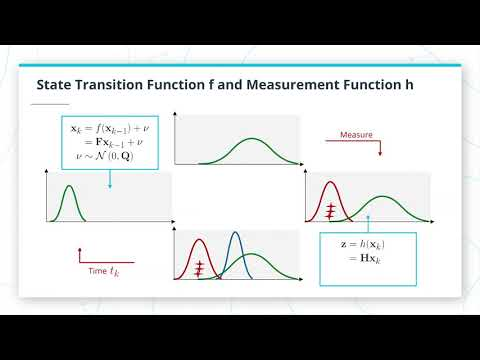

In [7]:
YouTubeVideo(id="LbkL7cCX_9g", width="719", height="404", rel=False, allow_autoplay=False)

Here we assume that our sensor measurements are obtained by a LiDAR sensor. Therefore, a linear measurement model $\mathrm{H}$ and a system matrix $\mathrm{F}$ in the linear case is sufficient for the following 1-D Kalman filter implementation:

* **System matrix** $\left(\mathrm{F}\right)$: the state transition function $f(x)$ in the linear case — models how the vehicle state has changed from time $t_{k-1}$ to $t_{k}$, assuming a constant velocity motion model;
* **Process noise covariance matrix** $\left(\mathcal{Q}\right)$ — here we model the uncertainty of the constant velocity object motion model to account for e.g., unexpected braking or acceleration;
    * A small covariance $Q$ indicates a small variances in our motion model assumption, i.e., we trust our motion model to have little noise. On the other hand, larger values of $Q$ indicate that we assume there to be a larger variance to the expected noise values due to e.g., unexpected braking or acceleration. For emergency braking systems, $Q$ should be sufficiently large as we know that quick braking will occur;
    * For process noise $\nu$ with equal values in both $x$- and $y$-axes, i.e., $\nu_{x} = \nu_{y}$, we have the continuous process noise covariance $\mathcal{Q}$ given by $\mathcal{Q} = E\left[\nu\nu^{\top}\right]$;
    * Discretising this continuous model gives us a formula for $\mathcal{Q}$ w.r.t. $\Delta{t}$ and design parameter $q$ — note that $q$ is selected in regards to the expected maximum change in velocity. For highly dynamic manoeuvres, a higher process noise e.g., $q = \left(8\frac{m}{s^2}\right)^{2}$, would be suitable for emergency braking, whereas for normal conditions — such as highway driving, a smaller process noise e.g., $q = \left(3\frac{m}{s^2}\right)^{2}$ would be sufficient;
* **State transition equation**: modelled by $\mathrm{x}_{k} = f\left(\mathrm{x}_{k-1}\right) + \nu = \mathrm{F}\mathrm{x}_{k-1} +\nu $ — here we add the zero-mean process noise $\nu \sim \mathcal{N}\left(0, \mathcal{Q}\right)$ with covariance $Q$;
* **Measurement matrix** $\left(\mathrm{H}\right)$: tells us how the measurement is related to the object — here the $\mathrm{H}$ matrix projects the 4D state space $\mathrm{x}$ to a 2D measurement $\mathrm{z}$;
* **Measurement noise covariance matrix** $\left(\mathrm{R}\right)$: tells us how much uncertainty exists in the position measurements received from the LiDAR sensor — here the off-diagonal $0$ entry values indicate the assumption that the process and measurement noise are uncorrelated in both the $x$- and $y$-axes;
    * Large entries in $\mathcal{R}$ tells us that the measurements are quite noisy and may differ a lot from the actual state;
    * For noise vector $\omega$ with same dimensions as $\mathrm{z}$, we have the zero-mean distribution represented by the $2x2$ covariance matrix given by the product $\mathrm{R} = E\left[\omega\omega^{\top}\right]$;
* **Measurement function**: modelled by $\mathrm{z} = h\left(\mathrm{x}_{k}\right) + \omega = \mathrm{H}\mathrm{x}_{k} + \omega$ — here we add the stochastic measurement noise $\omega \sim \mathcal{N}\left(0, \mathcal{R}\right)$ with covariance $\mathcal{R}$;
* **Motion model**: modelled by $p_{k} = p_{k-1} + v_{k-1}\Delta{t}$ and $v_{k} = v_{k-1}$ — here we assume a constant velocity, i.e., the new velocity is the same as the old velocity at the previous time-step;

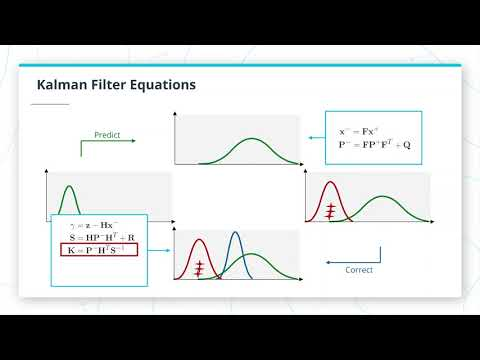

In [8]:
YouTubeVideo(id="7FarN1ovxEo", width="719", height="404", rel=False, allow_autoplay=False)

* **Prediction step**: modelled by $\mathrm{x}^{-} = \mathrm{F}\mathrm{x}^{+}$ and $\mathrm{P}^{-} = \mathrm{F}\mathrm{P}^{+}\mathrm{F}^{\top} + \mathcal{Q}$ — here we predict the state $\mathrm{x}$ and estimation error covariance $\mathrm{P}$ to the next time-step and apply a transformation to model the overall uncertainty;
    * The covariance $\mathrm{P}$ contains _variances_, i.e., squared standard deviations, meaning that we have to multiple twice with $\mathrm{F}$ and $\mathrm{F}^{\top}$;
* **Update step**: modelled by $\gamma = \mathrm{z} - \mathrm{H}\mathrm{x}^{-}$, $\mathrm{S} = \mathrm{H}\mathrm{P}^{-}\mathrm{H}^{\top} + \mathrm{R}$, $\mathrm{K} = \mathrm{P}^{-}\mathrm{H}^{\top}\mathrm{S}^{-1}$, $\mathrm{x}^{+} = \mathrm{x}^{-} + \mathrm{K}\gamma$ and $\mathrm{P}^{+} = \left(\mathrm{I} - \mathrm{K}\mathrm{H}\right)\mathrm{P}^{-}$ — here we first calculate the residual $\gamma$ which compares the state estimate $\mathrm{z}$ to the measurement space of $\mathrm{H}$. Then, we compute the covariance of the residual and transform the estimation error covariance $\mathrm{P}$ to the measurement space of $\mathrm{H}$. The Kalman gain $\mathrm{K}$ is computed to weight the prediction in comparison to the measurement, as shown in the update equation for $\mathrm{x}^{+}$;
    * The smaller the residual $\gamma$, the better our state estimation fits the measurement;
    * The transformation of the estimated position from world coordinates to the measurement space is referred to as a _projection_ of $\mathrm{x}$ into the image space of $\mathrm{H}$;
    * It is often easier to transform from state space to measurement space than vice-versa. For example, we can project a 3D point to an image, but not vice-versa since we lack information about the third coordinate $z$;
    * Here $\mathrm{I}$ refers to the Identity matrix with respect to the number of dimensions of matrix $\mathrm{P}$.

##### Extended Kalman Filter in 2-D

Recall that non-linear functions here use the lowercase notation, e.g., $h\left(\mathrm{x}\right)$, whereas linear systems here are denoted with uppercase notation, e.g., $\mathrm{H}$.

* **Camera sensor model**: modelled by $c = \left(c_{i}, c_{j}\right)$ and $f = \left(f_{i}, f_{j}\right)$ — here we form the image coordinates of the image centre, i.e., the principal point, and the focal length;
    * These parameters are defined in image space with respect to the camera intrinsic calibration matrix;
* **Measurement function** $h\left(\mathrm{x}\right)$: the non-linear measurement function used to map 6D state vector $\mathrm{x}$ into 2D image space;


Here we use a 2-D Extended Kalman Filter (EKF) to model a more complex measurement model — the non-linear camera measurement model. Previously, we used a 1-D assumption to handle the linear LiDAR sensor measurements. With the camera sensor, however, we no longer can assume this simplification will hold. Therefore, we must model the camera measurement function as a non-linear projection from 6D state vector space $\mathrm{x}$ into 2D image space. This yields a non-linear measurement function $h\left(\mathrm{x}\right)$ for a state vector $\left[p_{x}, p_{y}, p_{z}, v_{x}, v_{y}, v_{z}\right]^{\top}$ as follows:

$$
\begin{align}
h\left(\mathrm{x}\right) = \begin{pmatrix} c_{i} - \frac{f_{i}\cdot p_{y}}{p_x} \\ c_{j} - \frac{f_{j}\cdot p_{z}}{p_{x}}\end{pmatrix},
\end{align}
$$

such that the velocity components have been discarded.

Note that  $h\left(\mathrm{x}\right)$ is a multi-dimensional equation and therefore we must use a multi-dimensional Taylor series expansion to make a linear approximation of this measurement function. To save you time, we have provided the derivation of the $2x6$ Jacobian $\mathrm{H}_{J}$ that you will use in replace of the first-derivative $h^{\prime}\left(\mu\right)$ term from the first-order Taylor series expansion formula. That is,

$$
\begin{align}
\mathrm{H}_{J} &= 
    \begin{pmatrix}
        \frac{\partial h_{1}\left(\mathrm{x}\right)}{\partial p_{x}} & \frac{\partial h_{1}\left(\mathrm{x}\right)}{\partial p_{y}} & \frac{\partial h_{1}\left(\mathrm{x}\right)}{\partial p_{z}} & \frac{\partial h_{1}\left(\mathrm{x}\right)}{\partial v_{x}} & \frac{\partial h_{1}\left(\mathrm{x}\right)}{\partial v_{y}} & \frac{\partial h_{1}\left(\mathrm{x}\right)}{\partial v_{z}} \\
        \frac{\partial h_{2}\left(\mathrm{x}\right)}{\partial p_{x}} & \frac{\partial h_{2}\left(\mathrm{x}\right)}{\partial p_{y}} & \frac{\partial h_{2}\left(\mathrm{x}\right)}{\partial p_{z}} & \frac{\partial h_{2}\left(\mathrm{x}\right)}{\partial v_{x}} & \frac{\partial h_{2}\left(\mathrm{x}\right)}{\partial v_{y}} & \frac{\partial h_{2}\left(\mathrm{x}\right)}{\partial v_{z}}
    \end{pmatrix}. \\
\end{align}
$$

Calculating the entries of $\mathrm{H}_{J}$, and assuming all velocity components are zero, we obtain:

$$
\begin{align}
\mathrm{H}_{J} &=
    \begin{pmatrix}
    \frac{f_{i}\cdot p_{y}}{p_{x}^{2}} & -\frac{f_{i}}{p_{x}} & 0 & 0 & 0 & 0 \\
    \frac{f_{j}\cdot p_{z}}{p_{x}^{2}} & 0 & -\frac{f_{i}}{p_{x}} & 0 & 0 & 0 \\
    \end{pmatrix}.
\end{align}
$$

#### Linear versus non-linear functions

Before we jump into the coding part, we will first illustrate in this section why we need to perform a linear approximation of the camera measurement model. To do so, we will consider a toy Gaussian distribution to be our state vector data $\mathrm{x}$, Then, we will see what happens when we try to perform a transformation on this state vector with a non-linear measurement function $h\left(\mathrm{x}\right)$. This should make it clear why performing a transformation from multi-dimensional state vector into 2D measurement space is only possible with a linear function assumption.

##### An example distribution

To illustrate the impact of a non-linear transformation, we provide a simple test. As an example we will use a list of $10000$ random values drawn from $\mathcal{N} \sim \left(0, 3\right)$, i.e., a Gaussian normal distribution with a mean $\mu = 0$ and standard deviation $\sigma = 3$.

In [9]:
### Plotting the predicted state as a Guassian normal distribution

In [10]:
# Randomly sample from a Gaussian normal distribution
# See new `np.random` API guide: https://numpy.org/doc/stable/reference/random/index.html#quick-start
H = np.random.default_rng().normal(loc=0, scale=3, size=(10000,))

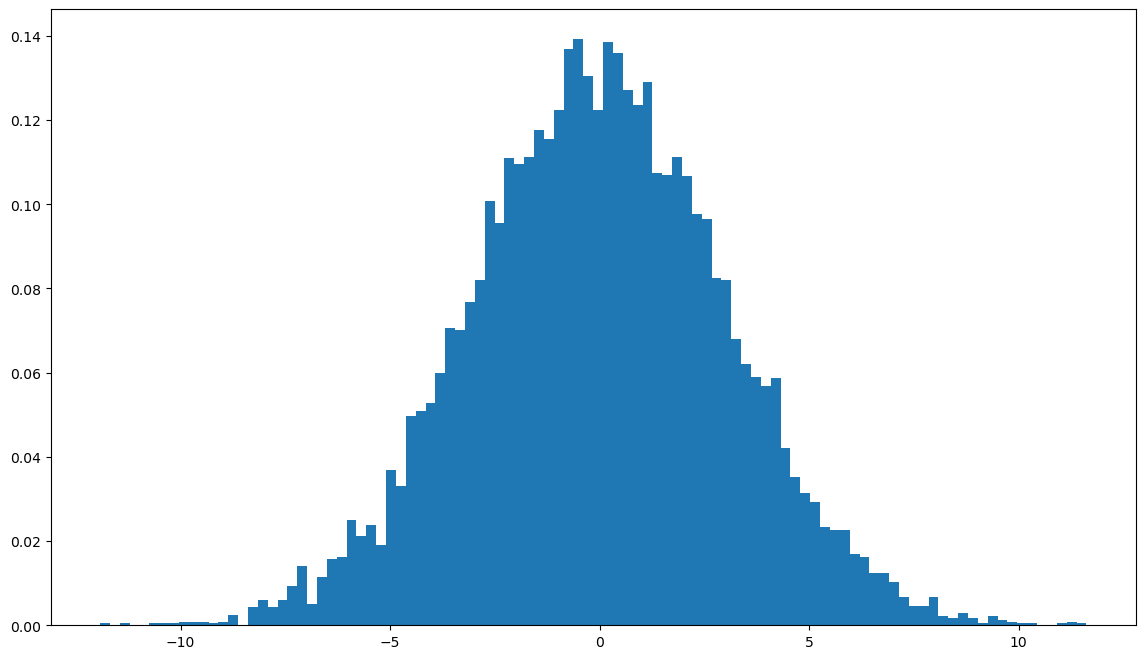

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(14, 8))
_ = axs.hist(H, bins=100, density=True)

Plotting the histogram above we see that this distribution indeed follows a Gaussian shape. Now let us explore the effect of applying a transformation function to the distribution above.

##### Linear functions

Suppose that our distribution above represents the data in our state vector $\mathrm{x}$. In both the _predict_ and the _update_ step equations we defined earlier we transform these values of $\mathrm{x}$ using either the measurement function $h\left(\mathrm{x}\right)$ or the state transition function $f\left(\mathrm{x}\right)$.

For the purposes of this example, let us assume a simple linear measurement function $h\left(\mathrm{x}\right)$ defined as follows:

$$
\begin{align}
h\left(\mathrm{x}\right) = \alpha * \mathrm{x} + \beta.
\end{align}
$$

Now let's apply this linear transformation function to the distribution above. 

In [12]:
### Compute the linear transformation of the measurement function h(x)
# Here we define the parameters of the linear transformation function h(x)
alpha = 2.0
beta = 1.0
transformation = np.array([[alpha, 0.], [0., beta]])
h_x = np.matmul(H.reshape(-1, 2), (transformation))

In [13]:
### Plotting the transformation using a 1-D measurement function

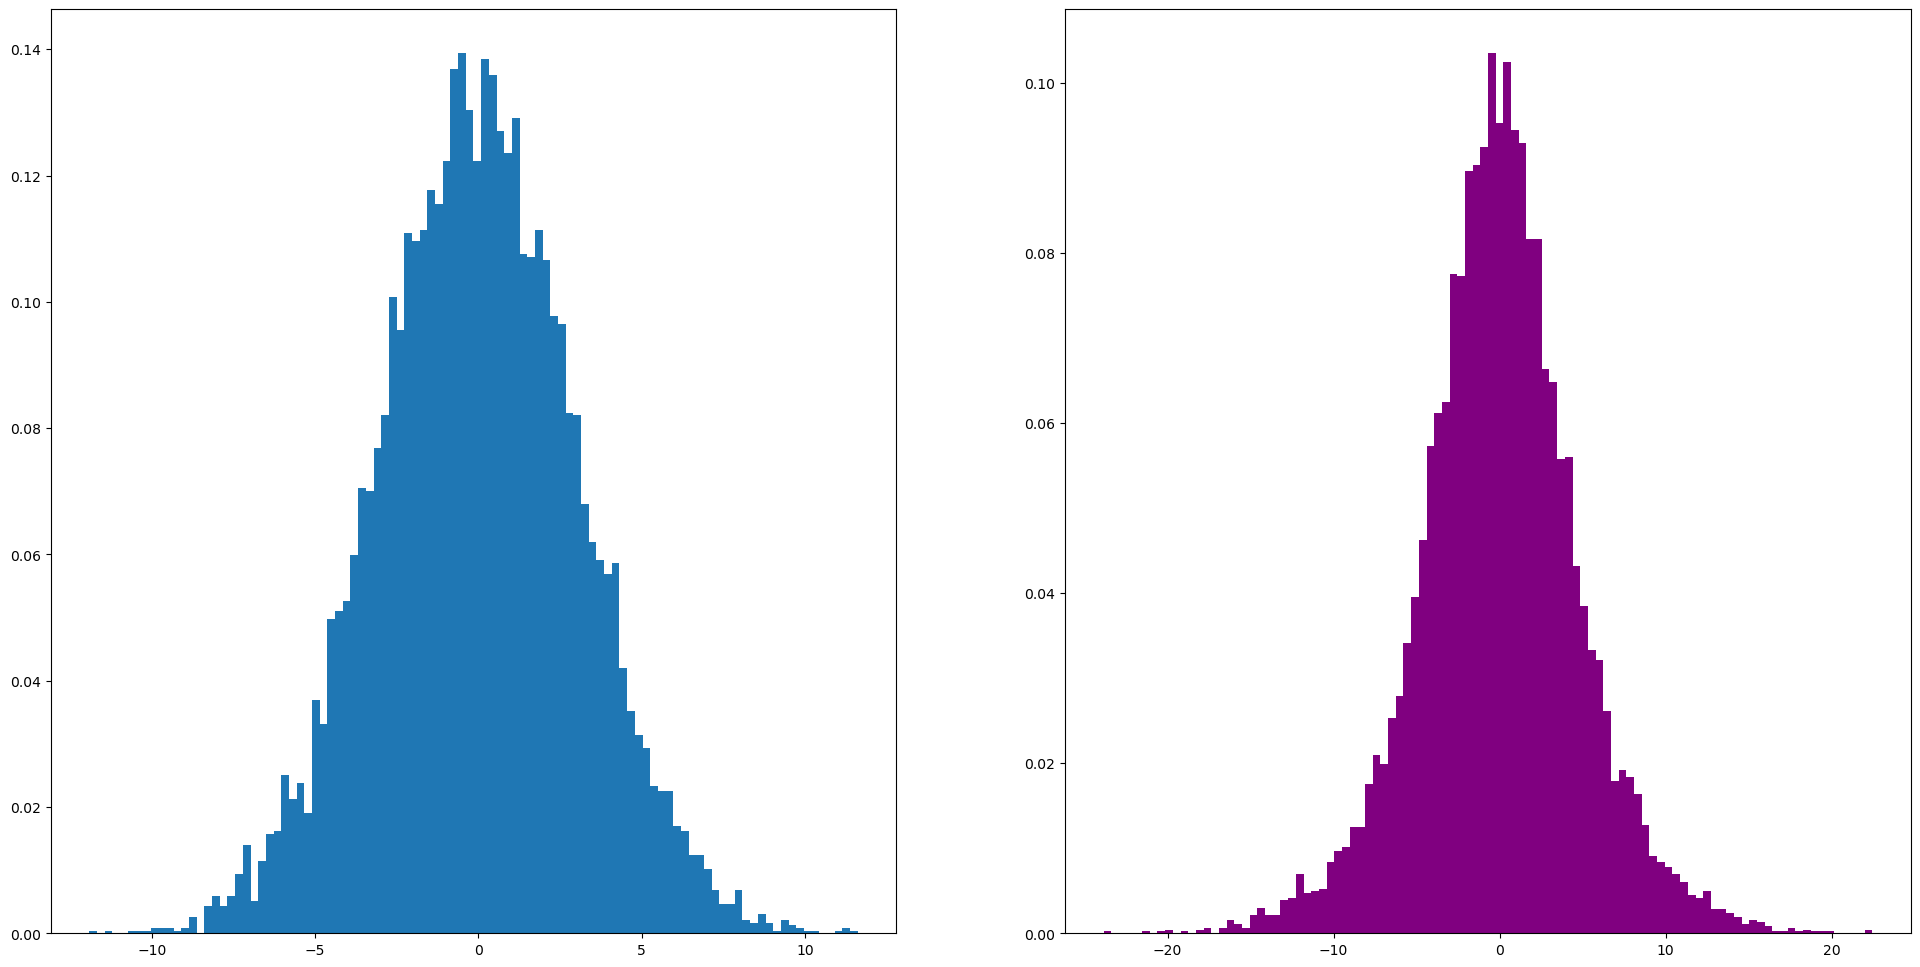

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(24, 12))
_ = axs[0].hist(H, bins=100, density=True, label='Original distribution')
_ = axs[1].hist(h_x.flatten(), bins=100, density=True, color='purple', label='After linear transformation')

Note that the resulting distribution shown in purple (right) maintains a Gaussian shape after the transformation is applied. Therefore, we can safely proceed with the 1-D Kalman filter equations we defined earlier, assuming that this linearity holds.

##### Non-linear functions

Now we repeat the transformation for a non-linear function:

$$
\begin{align}
h\left(\mathrm{x}\right) = \arctan\left(\mathrm{x}\right).
\end{align}
$$

In [15]:
### Computing the non-linear transformation of the measurement function h(x)
h_x = np.arctan(H)

In [16]:
### Plotting the transformation using a non-linear measurement function

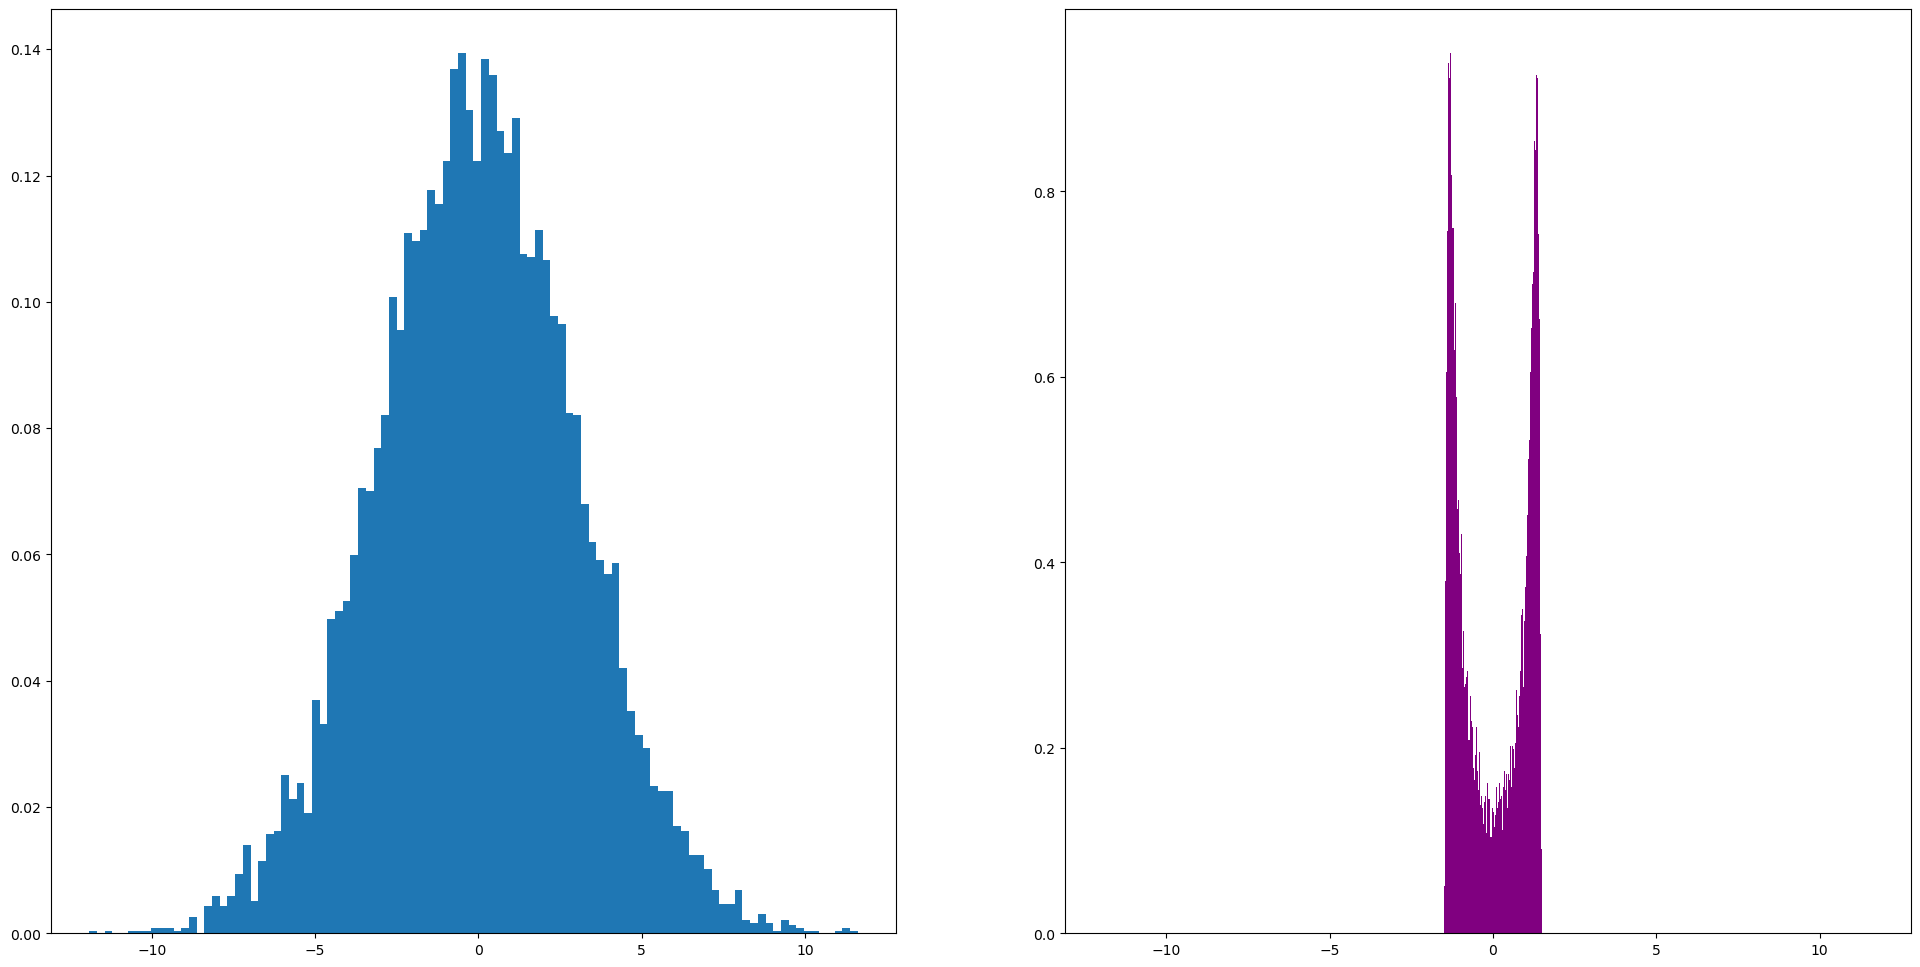

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(24, 12), sharex=True)
_ = axs[0].hist(H, bins=100, density=True, label='Original distribution')
_ = axs[1].hist(h_x, bins=100, density=True, color='purple', label='After non-linear transformation')

Here we see that the output distribution shown in purple (right) no longer follows a Gaussian shape. Therefore, the 1-D Kalman update equations are _no longer applicable_.

If we want to apply the Extended Kalman Filter (EKF), we must first construct a linear approximation of $h\left(\mathrm{x}\right)$.

##### Linear approximations

In order to linearise a non-linear function we must perform linear function approximation. To do so, we use a first-order Taylor Expansion. First, we evaluate the linear function $\mathrm{H}$ at the mean location $\mu$. Then, we extrapolate the line around $\mu$ with the slope given by the first derivative of $\mathrm{H}$. With a value of $\mu$ sufficiently close to $x$, we can ignore the higher-order terms of the Taylor series to obtain:

$$
\begin{align}
h\left(x\right) \approx h\left(\mu\right) + h^{\prime}\left(\mu\right)\left(x - \mu\right),
\end{align}
$$

i.e., the linear approximation of the non-linear measurement function $h(\mathrm{x})$. Assuming also that the state transition function $f(x)$ is non-linear, we repeat the process using exactly the same linearisation technique.

The Extended Kalman Filter (EKF) allows us to transform the non-linear camera measurement model derived above to a [Jacobian matrix](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant) $\mathrm{H}_{J}\left(\mu\right)$. With this we can replace the first derivative $h^{\prime}\left(\mu\right)$ of the Taylor series above with the Jacobian matrix $\mathrm{H}_{J}$ containing the partial derivatives of the multi-dimensional measurement function $h$.


For the non-linear measurement function $h\left(\mathrm{x}\right) = \arctan\left(\mathrm{x}\right)$ we previously defined, assuming that we have a predicted state with mean $\mu = 0$, we evaluate the first-order Taylor series as:

$$
h\left(\mathrm{x}\right) \approx \arctan\left(0\right) + \frac{1}{1 + 0^2}\cdot\left(x - 0\right),
$$

which gives us the linear approximation $h\left(\mathrm{x}\right) \approx x$.

Now let's see this what happens when we transform our initial distribution with this linear approximation... 

In [18]:
### Computing the linear transformation of the linearised measurement function h(x)
g_x = np.array([[1., 0.], [0., 0.]])      # The linearised transformation matrix
h_x = np.matmul(H.reshape(-1, 2), g_x)    # g(x) = H * h(x)

In [19]:
### Plotting the transformation using a linearised measurement function

(0.0, 0.07)

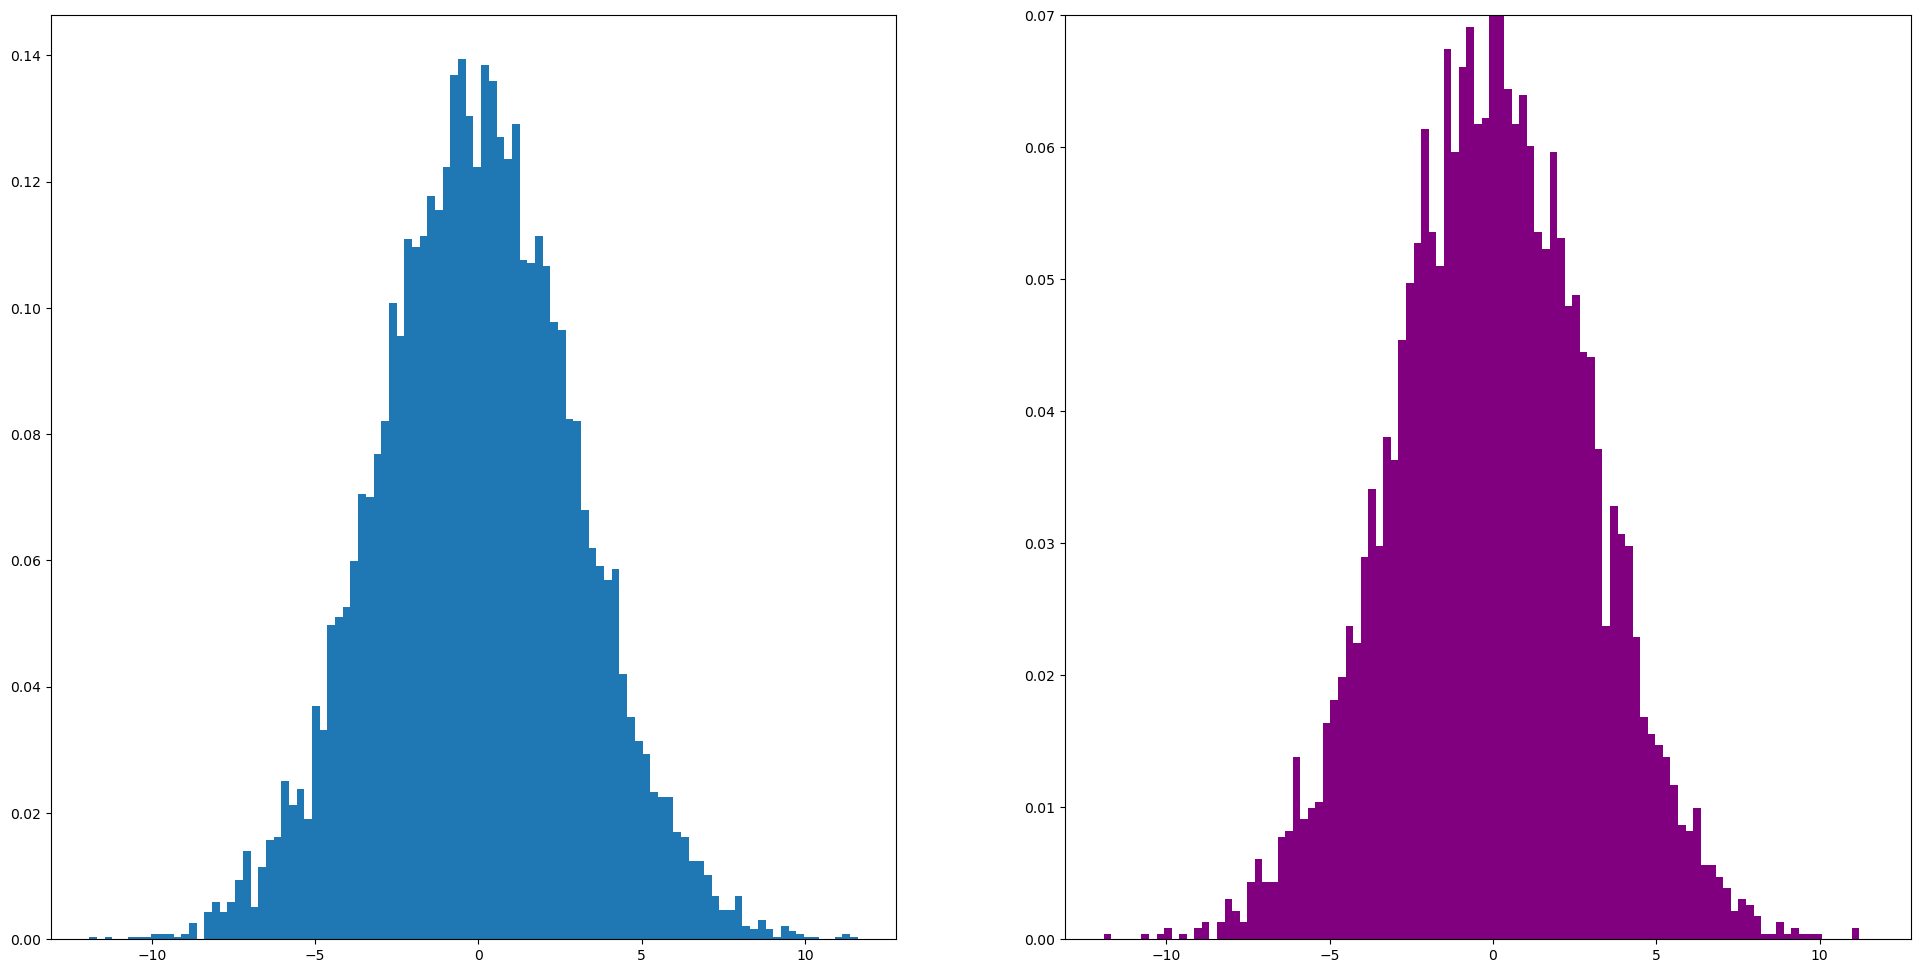

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(24, 12), sharex=True)
_ = axs[0].hist(H, bins=100, density=True,
                                label='Original distribution')
_ = axs[1].hist(h_x.flatten(), bins=100, density=True, color='purple',
                                label='After non-linear transformation')
axs[1].set_ylim(top=0.07)

From the above we see that our linearised function $h\left(\mathrm{x}\right) \approx \mathrm{x}$ results in a transformation that roughly approximates a Gaussian shape, as shown on the right in purple.

Great! This means that we will be able to preserve the Kalman filter update and predict equations as long as we appropriately linearise the camera measurement function $h\left(\mathrm{x}\right)$ and state transition function $f\left(\mathrm{x}\right)$.

#### Recap

Based on what you have learned, you should realise that the Kalman filter equations in 1-D and 2-D are not that much different than the Extended Kalman Filter equations in the non-linear case.

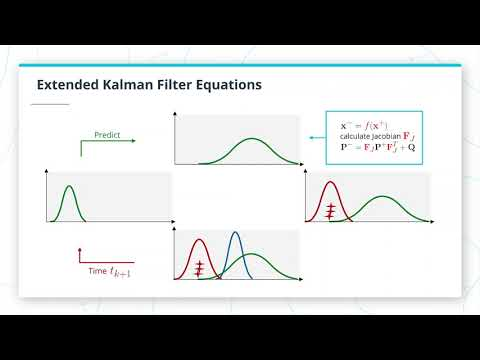

In [21]:
YouTubeVideo(id="XQjIcx-EWLI", width="719", height="404", rel=False, allow_autoplay=False)

In summary, we make the following changes to the Kalman filter equations when using the non-linear camera model:
* **System matrix**: the linear $\mathrm{F}$ matrix will be replaced by the Jacobian $\mathrm{F}_{J}$ when calculating the covariance $\mathrm{P}^{-}$;
* **Measurement matrix**: the linear $\mathrm{H}$ matrix will be replaced by the Jacobian $\mathrm{H}_{J}$ when calculating $\mathrm{S}$, $\mathrm{K}$, and $\mathrm{P}^{+}$;
* **Predict step**: the prediction update function $f\left(\mathrm{x}\right)$ equation is used instead of the linear system matrix $\mathrm{F}$;
* **Update step**: the measurement function $h\left(\mathrm{x}\right)$ is used to update the residual $\gamma$ instead of the linear measurement matrix $\mathrm{H}$.

Note that for the final project we will not be using the extended equations in replace of the system matrix $\mathrm{F}$. This is because we assume a linear model for the prediction step, and therefore do not need to utilise the non-linear function $f\left(\mathrm{x}\right)$ or Jacobian $\mathrm{F}_{J}$. Similarly, we will only need to modify the measurement update step for the camera model, as it is a non-linear system. That is, we use the camera measurement function $h\left(\mathrm{x}\right)$ to directly map predicted locations $\mathrm{x}^{-}$ from Cartesian coordinates to image coordinates. Importantly, the residual update equation $\gamma = \mathrm{z} - \mathrm{H}\mathrm{x}$ does not become $\gamma = \mathrm{z} - \mathrm{H}_{J}\mathrm{x}$ in the extended case, but rather the function $h\left(\mathrm{x}\right)$ is used directly. We'll cover this in more detail when the time comes, but for now — don't worry. You have got all the tools you need to dive right into the programming for this task!

If you have any struggles, feel free to open an Issue on [ND0013-Self-Driving-Car-Engineer](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer) and make sure to review the awesome [lecture videos by Dr. Antje Muntzinger](https://www.youtube.com/playlist?list=PL6nu8g-5OMNgl_rtYmrGa-K4lkjcTJbL5) — you'll be really happy you did!

## 2. Programming Task

We have covered a lot of information thus far about the Extended Kalman Filter (EKF) and the difference between linear and non-linear transformations. Together with the formulas provided above, you should find that the programming tasks in this module are relatively simple — you are expected to implement these formulas almost verbatim and observe the results of the tracking algorithm on experimental data.

### 2.1. The LiDAR Sensor

Here we implement the linear Extended Kalman Filter (EKF) in the 1-D case for the LiDAR sensor model.

Recall the 1-D Kalman filter equations derived in Section 1, as we will be implementing them verbatim in this exercise.

#### 2.1.1. The 1-D Kalman Filter

In [22]:
### From J. Moran's `1_predict_update.py`
# Credit: https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/main/2-Sensor-Fusion/Exercises/2-3-Extended-Kalman-Filters/exercises/1_predict_update.py

In [23]:
class Filter:
    '''The Kalman filter class.

    Implements the 1-D Kalman filter using State space form.
    
    Here we assume the process noise and measurement error to be modelled by
    Gaussian distributions with known covariance s.t. they remain stationary
    over time. This allows us to construct the filter as a MSE minimisation
    problem.

    :param dim_state: the number of dimensions of the process model `P`.
    :param u: the external motion model.
    :param F: the state transition matrix in the linear case
        i.e., system matrix.
    :param Q: the process noise covariance matrix, sampled at random from
        a Gaussian normal distribution.
    :param H: the measurement function relating the measurement and the motion
        of the object from one time-step to the next.
    '''

    def __init__(self):
        """Initialises the Kalman filter object with given dimensionality."""

        # The number of dimensions of the process model
        self.dim_state = 2
        # The external motion model (not used for this problem)
        self.u = np.array([[0., 0.]])
        # Instantiate the state transition matrix (i.e., system matrix)
        self.F = self.F()
        # Instantiate the process noise covariance matrix
        self.Q = self.Q()
        # Instantiate the measurement function
        self.H = self.H()


    def F(self
    ) -> np.ndarray:
        """Implements the state transition matrix.

        We refer to `F` as the system matrix, i.e., a linear matrix
        function governing the object movement model over time.

        :returns: F, the linear system matrix.
        """

        return np.array([[1, 1],
                         [0, 1]])

    def Q(self
    ) -> np.ndarray:
        """Implements the process noise covariance matrix.

        We refer to `Q` as the process noise covariance matrix, i.e.,
        the covariance of the process noise modelled after the stochastic
        variable $\nu$ from a Gaussian distribution with zero cross-correlation
        to the measurement noise.

        The larger the values of `Q`, the higher the expectation of noise.
        In e.g., an emergency braking system of a vehicle, `Q` might have
        relatively large values as the object motion model produces estimates
        with high uncertainty due to e.g., unexpected braking or acceleration.

        :returns: Q, the process noise covariance matrix.
        """

        return np.array([[0, 0],
                         [0, 0]])
        
    def H(self
    ) -> np.ndarray:
        """Implements the measurement function.

        We refer to `H` as a deterministic function relating the measurement
        of an object from time-step $t_{k-1}$ to $t_{k}$. The matrix `H` is
        the noiseless connection between the state vector and the measurement
        vector and is assumed to be stationary over time.

        :returns: H, the measurement matrix.
        """

        return np.array([[1, 0]])
    
    def predict(self, 
            x: np.ndarray, P: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray]:
        """Implements the prediction step.

        The state estimate and covariance matrix are updated with respect to the
        next time-step.

        :param x: the observed state estimate from the previous time-step,
            i.e., $x^{+}$, the state estimate updated w.r.t. the weighted
            measurement observed at time $t_{k}$.
        :param P: the covariance matrix from the previous time-step,
            i.e., $P^{+}$, the covariance matrix updated w.r.t. the weighted
            measurement observed at time $t_{k}$.
        :returns: tuple, the predicted state estimate and covariance matrix.
        """

        ### Project the state estimate into the next time-step
        # Here we update the motion from $t_{k}$ to $t_{k+1}$
        x = self.F @ x + self.u
        ### Project the covariance matrix into the next time-step
        # Here the covariance process noise matrix `Q` accounts for uncertainty
        # in object motion model due to e.g., unexpected braking / acceleration.
        P = np.matmul(self.F @ P, self.F.T) + self.Q
        return x, P

    def update(self, 
            x: np.ndarray, P: np.ndarray, z: np.ndarray, R: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray]:
        """Implements the update step.

        Also referred to as the 'correction' step, here the state estimate and
        the covariance matrix are updated w.r.t. the measurement observed at
        time $t_{k}$.

        :param x: the state estimate obtained from the previous time-step,
            i.e., $x^{-}$, the predicted state estimate.
        :param P: the covariance matrix from the previous time-step,
            i.e., $P^{-}$, the predicted process noise covariance matrix.
        :param z: the estimate obtained from the previous time-step,
            i.e., the weighted predicted position and velocity of the object.
        :param R: the measurement noise covariance matrix,
            i.e., the model of expected error in the measurement observations.
        :returns: tuple, the updated state estimate and covariance matrix.
        """

        ### Compute the measurement residual update step (i.e., innovation step)
        # Here we compare the new measurement `z` with the prev. state estimate
        # transformed to the measurement space by matrix `H`
        gamma = z - self.H @ x
        ### Compute the covariance of the residual update
        # Here we transform the estimation error from covariance matrix `P` to
        # measurement space given by $H^{\top}H$ then add measurement noise `R`
        S = np.matmul(self.H @ P, self.H.T) + R
        ### Compute the Kalman gain
        # Here we weight the predicted state in comparison to the measurement
        K = np.matmul(P @ self.H.T, np.linalg.inv(S))
        ### Update the state estimate w.r.t. the weighted measurement
        # Here we give greater weight to either the measurement or the prev.
        # estimate using the Kalman gain `K`, i.e., the larger `K` the greater
        # the weight given to the residual measurement `gamma`
        x = x + K @ gamma
        ### Update the covariance matrix w.r.t. the weighted measurement
        # Here the identity $ P_{K} \times P_{k}^{-1} = I $ is used
        P = (np.identity(n=self.dim_state) - np.matmul(K, self.H)) @ P
        return x, P  

##### Testing the 1-D Kalman Filter

In [24]:
### From J. Moran's `1_predict_update.py`
# Credit: https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/main/2-Sensor-Fusion/Exercises/2-3-Extended-Kalman-Filters/exercises/1_predict_update.py

In [25]:
def run_filter(
) -> Tuple[np.ndarray, np.ndarray]:
    """Performs Kalman filtering over the measurement data.

    :returns: tuple, the final position / velocity estimates along with
        the weighted covariance matrix.
    """

    ### Fix the seed s.t. random values are predictable
    np.random.seed(10)
    ### Instantiate the Kalman filter object
    KF = Filter()
    ### Initialise the tracking state vector and covariance matrix
    x = np.array([[0],
                  [0]])
    P = np.array([[5**2, 0],
                  [0, 5**2]])
    ### Loop over the measurements and call predict and update
    for i in range(1,101):        
        print('------------------------------')
        print('processing measurement #' + str(i))
        ### Perform the prediction step
        x, P = KF.predict(x, P) # predict to next timestep
        print('x- =', x)
        print('P- =', P)
        ### Obtain the measurement model
        # Model the measurement noise
        sigma_z = 1
        # Initialise the noise at random from a Guassian normal distribution
        z = np.array([[i + np.random.normal(0, sigma_z)]])
        # Initialise the measurement covariance matrix
        R = np.array([[sigma_z**2]])
        print('z =', z)
        ### Perform the update step
        # Update the state vector and covariance matrix with the measurement
        x, P = KF.update(x, P, z, R)
        print('x+ =', x)
        print('P+ =', P)
    return x, P

In [26]:
### Testing the 1-D Kalman filter tracking

In [27]:
# Obtain the final position / velocity and covariance estimates
x_final, P_final = run_filter()

In [28]:
# Print the final position estimate
x_final[0][0]

99.95080428080236

In [29]:
# Print the final velocity estimate
x_final[1][0]

0.9974034707222009

In [30]:
# Check against the expected result
assert np.isclose(x_final[0][0], 100.0, rtol=0.05)   # Position at $x=100.0$
assert np.isclose(x_final[1][0], 1.0, rtol=0.02)     # Velocity at $v=1.0$

#### 2.1.2. The 2-D Kalman Filter

Here we build upon the 1-D Kalman Filter (EKF) above for the 2-D case.

In this implementation we will be defining the system matrix $\mathrm{F}$, the process noise covariance $\mathcal{Q}$, and the measurement matrix $\mathrm{H}$ for a linear EKF. We assume the constant velocity model with a discretised continuous process noise function using the provided parameter values of $\Delta{t}$ and $q$.

In [31]:
### From J. Moran's `2_filter.py`
# Credit: https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/main/2-Sensor-Fusion/Exercises/2-3-Extended-Kalman-Filters/exercises/2_filter.py

In [32]:
class Filter:
    '''The Kalman filter class.

    Implements the 2-D Kalman filter using State space form.

    Here we assume the process noise and measurement error are modelled by
    Gaussian distributions. The process noise is assumed to have zero-mean and
    depends on both the elapsed time-step $\Delta{t}$ and the uncertainty of the
    object motion w.r.t. acceleration as modelled by covariance matrix $Q$.

    The discretisation of $Q$ is such that noise through acceleration is assumed
    to be equal in both $x$ and $y$, i.e., $ \nu{x} = \nu{y} $.

    :param dim_state: the dimensions of the process model `P`.
    :param dt: the discrete time-step, i.e., $\Delta{t}$, which is no longer
        assumed to be constant as in the 1-D case.
    :param q: the design parameter of the covariance process noise matrix $Q$,
        which is selected w.r.t. the expected maximum change in velocity.
    :param F: the state transition matrix in the 2-D filter case.
    :param Q: the discretised process noise covariance matrix.
    :param H: the measurement projection matrix of the linear LiDAR sensor.
    '''

    def __init__(self):
        """Initialises the Kalman filter object with given dimensionality."""
        
        # The number of dimensions of the process model
        self.dim_state = 4
        # The external motion model (not used for this problem)
        self.u = np.array([[0., 0.]])
        # Set the discrete time-step (measured in seconds, s)
        self.dt = 0.1
        # The design parameter of the covariance process noise
        self.q = 0.1
        # Instantiate the state transition matrix
        self.F = self.F()
        # Instantiate the process noise covariance matrix
        self.Q = self.Q()
        # Instantiate the measurement projection matrix
        self.H = self.H()

    def F(self
    ) -> np.ndarray:
        """Implements the state transition matrix.

        Here we assume a linear motion model with constant velocity in 2-D,
        i.e., $F$ is a 4-D state matrix of position and velocity estimated
        in both $x$ and $y$.

        :returns: F, the state transition matrix.
        """
        
        return np.array([[1., 0., self.dt, 0.],
                         [0., 1., 0., self.dt],
                         [0., 0., 1., 0.],
                         [0., 0., 0., 1.]])

    def Q(self
    ) -> np.ndarray:
        """Implements the process noise covariance matrix.

        We refer to `Q` as the process noise covariance matrix, i.e.,
        the covariance of the process noise modelled after the variable
        $\nu$ from a Gaussian distribution with zero-cross correlation to
        the measurement noise.

        The discretisation of $Q$ is such that noise through acceleration
        is assumed to be equal in both $x$ and $y$, i.e.,
            $ \nu_{x} = \nu_y} $.

        The $Q$ matrix depends on both the time-step $\Delta{t}$ and a process
        noise covariance design parameter `q`, which is selected w.r.t. the
        expected maximum change in velocity. For highly-dynamic manoeuvres,
        a higher parameter value, e.g., $q = 8 m/s^2$ is sufficient for
        emergency braking systems, whereas smaller values of `q`, e.g.,
        $q = 3 m/s^2$, are sufficient for normal driving conditions such as the
        highway driving scenario.

        :returns Q: the process noise covariance matrix.
        """

        return np.array([
            [self.dt**3 * self.q / 3., 0., self.dt**2 * self.q / 2., 0.],
            [0., self.dt**3 * self.q / 3., 0., self.dt**2 / 2.],
            [self.dt**2 * self.q / 2., 0., self.dt * self.q, 0.],
            [0., self.dt**2 * self.q / 2., 0., self.dt * self.q]])
    
    def H(self
    ) -> np.ndarray:
        """Implements the measurement function.

        We refer to `H` as the projection matrix from the 4-D state space of the
        object to the 2-D measurement space of the sensor, in this case, the
        linear LiDAR sensor.

        Here we discard the velocity information, $(v_{x}, v_{y})$, from the
        predicted state vector $ x = (p_{x}, p_{y}, v_{x}, v_{y})^{\top} $.
        This allows us to correctly project the 2-D components of position into
        the measurement space.

        :returns: H, the measurement model of the linear LiDAR sensor in 2-D.
        """

        return np.array([[1., 0., 0., 0.],
                         [0., 1., 0., 0.]])
    
    def predict(self,
            x: np.ndarray, P: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray]:
        """Implements the prediction step.

        The state estimate and covariance matrix are updated with respect to the
        next time-step.
        
        :param x: the observed state estimate from the previous time-step,
            i.e., $x^{+}$, the state estimated w.r.t. the weighted
            measurement observed at time $t_{k}$.
        :param P: the covariance matrix from the previous time-step,
            i.e., $P^{+}$, the covariance matrix updated w.r.t. the
            weighted measurement observed at time $t_{k}$.
        :returns: tuple, the predicted state estimate and covariance matrix.
        """

        ### Project the state estimate into the next time-step
        # Here we update the motion from $t_{k}$ to $t_{k+1}$
        x = self.F @ x + self.u
        ### Project the covariance matrix into the next time-step
        # Here the covariance process noise matrix `Q` accounts for uncertainty
        # in object motion model due to e.g., unexpected braking / acceleration
        P = np.matmul(self.F @ P, self.F.T) + self.Q
        return x, P

    def update(self,
            x: np.ndarray, P: np.ndarray, z: np.ndarray, R: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray]:
        """Implements the update step.

        Also referred to as the 'correction' step, here the state estimate and
        the covariance matrix are updated w.r.t. the measurement observed at
        time $t_{k}$.

        :param x: the state estimate obtained from the previous time-step,
            i.e., $x^{-}$, the predicted state estimate.
        :param P: the covariance matrix from the previous time-step,
            i.e., $P^{-}$, the predicted process noise covariance matrix.
        :param z: the estimate obtained from the previous time-step,
            i.e., the weighted predicted position and velocity of the object.
        :param R: the measurement noise covariance matrix,
            i.e., the model of expected error in the measurement observations.
        :returns: tuple, the updated state estimate and covariance matrix.
        """

        ### Compute the measurement residual update step (i.e., innovation step)
        # Here we compare the new measurement `z` with the prev. state estimate
        # transformed to the measurement space by `H`
        gamma = z - self.H @ x
        ### Compute the covariance of the residual update
        # Here we transform the estimation error from covariance matrix `P` to
        # measurement space given by $H^{\top}H$ then add measurement noise `R`
        S = np.matmul(self.H @ P, self.H.T) + R
        ### Compute the Kalman gain
        # Here we weight the predicted state in comparison to the measurement
        K = np.matmul(P @ self.H.T, np.linalg.inv(S))
        ### Update the state estimate w.r.t. the weighted measurement
        # Here we give greater weight to either the measurement or the prev.
        # estimate using the Kalman gain `k`, i.e., the larger the `K` the greater
        # the weight given to the residual measurement `gamma`
        x = x + K @ gamma
        ### Update the covariance matrix w.r.t. the weighted measurement
        # Here the identity $ P_{k} \times P_{k}^{-1} = I $ is used
        I = np.identity(n=self.dim_state)
        P = (I - np.matmul(K, self.H)) @ P
        return x, P

##### Testing the 2-D Kalman Filter

In [33]:
### From J. Moran's `2_filter.py`
# Credit: https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/main/2-Sensor-Fusion/Exercises/2-3-Extended-Kalman-Filters/exercises/2_filter.py

In [34]:
def run_filter():
    """Performs Kalman filtering over the measurement data."""
    
    # Fix the seed s.t. random values are predictable
    np.random.seed(0)
    # Instantiate the Kalman filter object
    KF = Filter()
    # Initialise the Matplotlib figure
    fig, ax = plt.subplots(figsize=(24, 20))
    # Initialise the track state vector and covariance matrix
    x = np.array([[0],
                  [0],
                  [0],
                  [0]]
    )
    P = np.array([[0.1**2, 0, 0, 0],
                  [0, 0.1**2, 0, 0],
                  [0, 0, 2**2, 0],
                  [0, 0, 0, 2**2]]
    )
    # Loop over the measurements and call `predict` and `update`
    for i in range(1, 101):
        ### Perform the prediction step
        # Here we predict to the next time-step
        x, P = KF.predict(x, P)
        # Here we generate the ground-truth observation as a
        # non-linear motion model
        gt = np.array([[i * KF.dt], 
                       [0.1 * (i * KF.dt)**2]]
        )
        ### Obtain the measurement using a linear motion model
        # The measurement noise constant to account for discrepency
        # between linear and non-linear motion models
        sigma_z = 0.2
        # Here we generate a noisy measurement from a Guassian normal distribution
        z = np.array([[float(gt[0]) + np.random.normal(0, sigma_z)],
                      [float(gt[1]) + np.random.normal(0, sigma_z)]]
        )
        # Here we generate the measurement noise covariance matrix
        # which is the uncertainty in the position measurements received by the
        # LiDAR sensor modelled by the the standard deviations of the detections
        # in $x$ and $y$ along the diagonal of $R$
        # Note that the off-diagonal 0s here indicate that the noise in $x$ and $y$
        # are in fact uncorrelated, per the assumption made w.r.t. $\gamma$
        R = np.array([[sigma_z**2, 0],
                      [0, sigma_z**2]]
        )
        ### Perform the update step
        # Update the state and covariance matrix with the measurement
        x, P = KF.update(x, P, z, R)
        ### Visualise the predicted and ground-truth tracks
        # Plot the tracks
        ax.scatter(np.float_(x[0]).tolist(), np.float_(x[1]).tolist(),
                            color='green', s=40, marker='x', label='Track'
        )
        # Plot the measured position estimates
        ax.scatter(np.float_(z[0]).tolist(), np.float_(z[1]).tolist(),
                            color='blue', marker='.', label='Measurement'
        )
        # Plot the ground-truth positions
        ax.scatter(np.float_(gt[0]).tolist(), np.float_(gt[1]).tolist(),
                            color='gray', s=40, marker='+', label='Ground truth'
        )
        ax.set_xlabel('x [m]', fontsize=16)
        ax.set_ylabel('y [m]', fontsize=16)
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)
        # Maximise the figure window if using `wxagg` backend
        if matplotlib.rcParams['backend'] == 'wxagg':
            mng = plt.get_current_fig_manager()
            mng.frame.Maximize(True)
        # Remove any repeated labels from the plot
        handles, labels = ax.get_legend_handles_labels()
        handle_list, label_list = [], []
        for handle, label in zip(handles, labels):
            if label not in label_list:
                handle_list.append(handle)
                label_list.append(label)
        ax.legend(handle_list, label_list, loc='lower right',
                            shadow=True, fontsize='x-large'
        )
        ax.set_title('2-D Kalman filtering: Position tracked over time',
                            fontsize=20
        )
        # Uncomment if running in interactive window (used for animation)
        # plt.pause(0.01)
    plt.show()

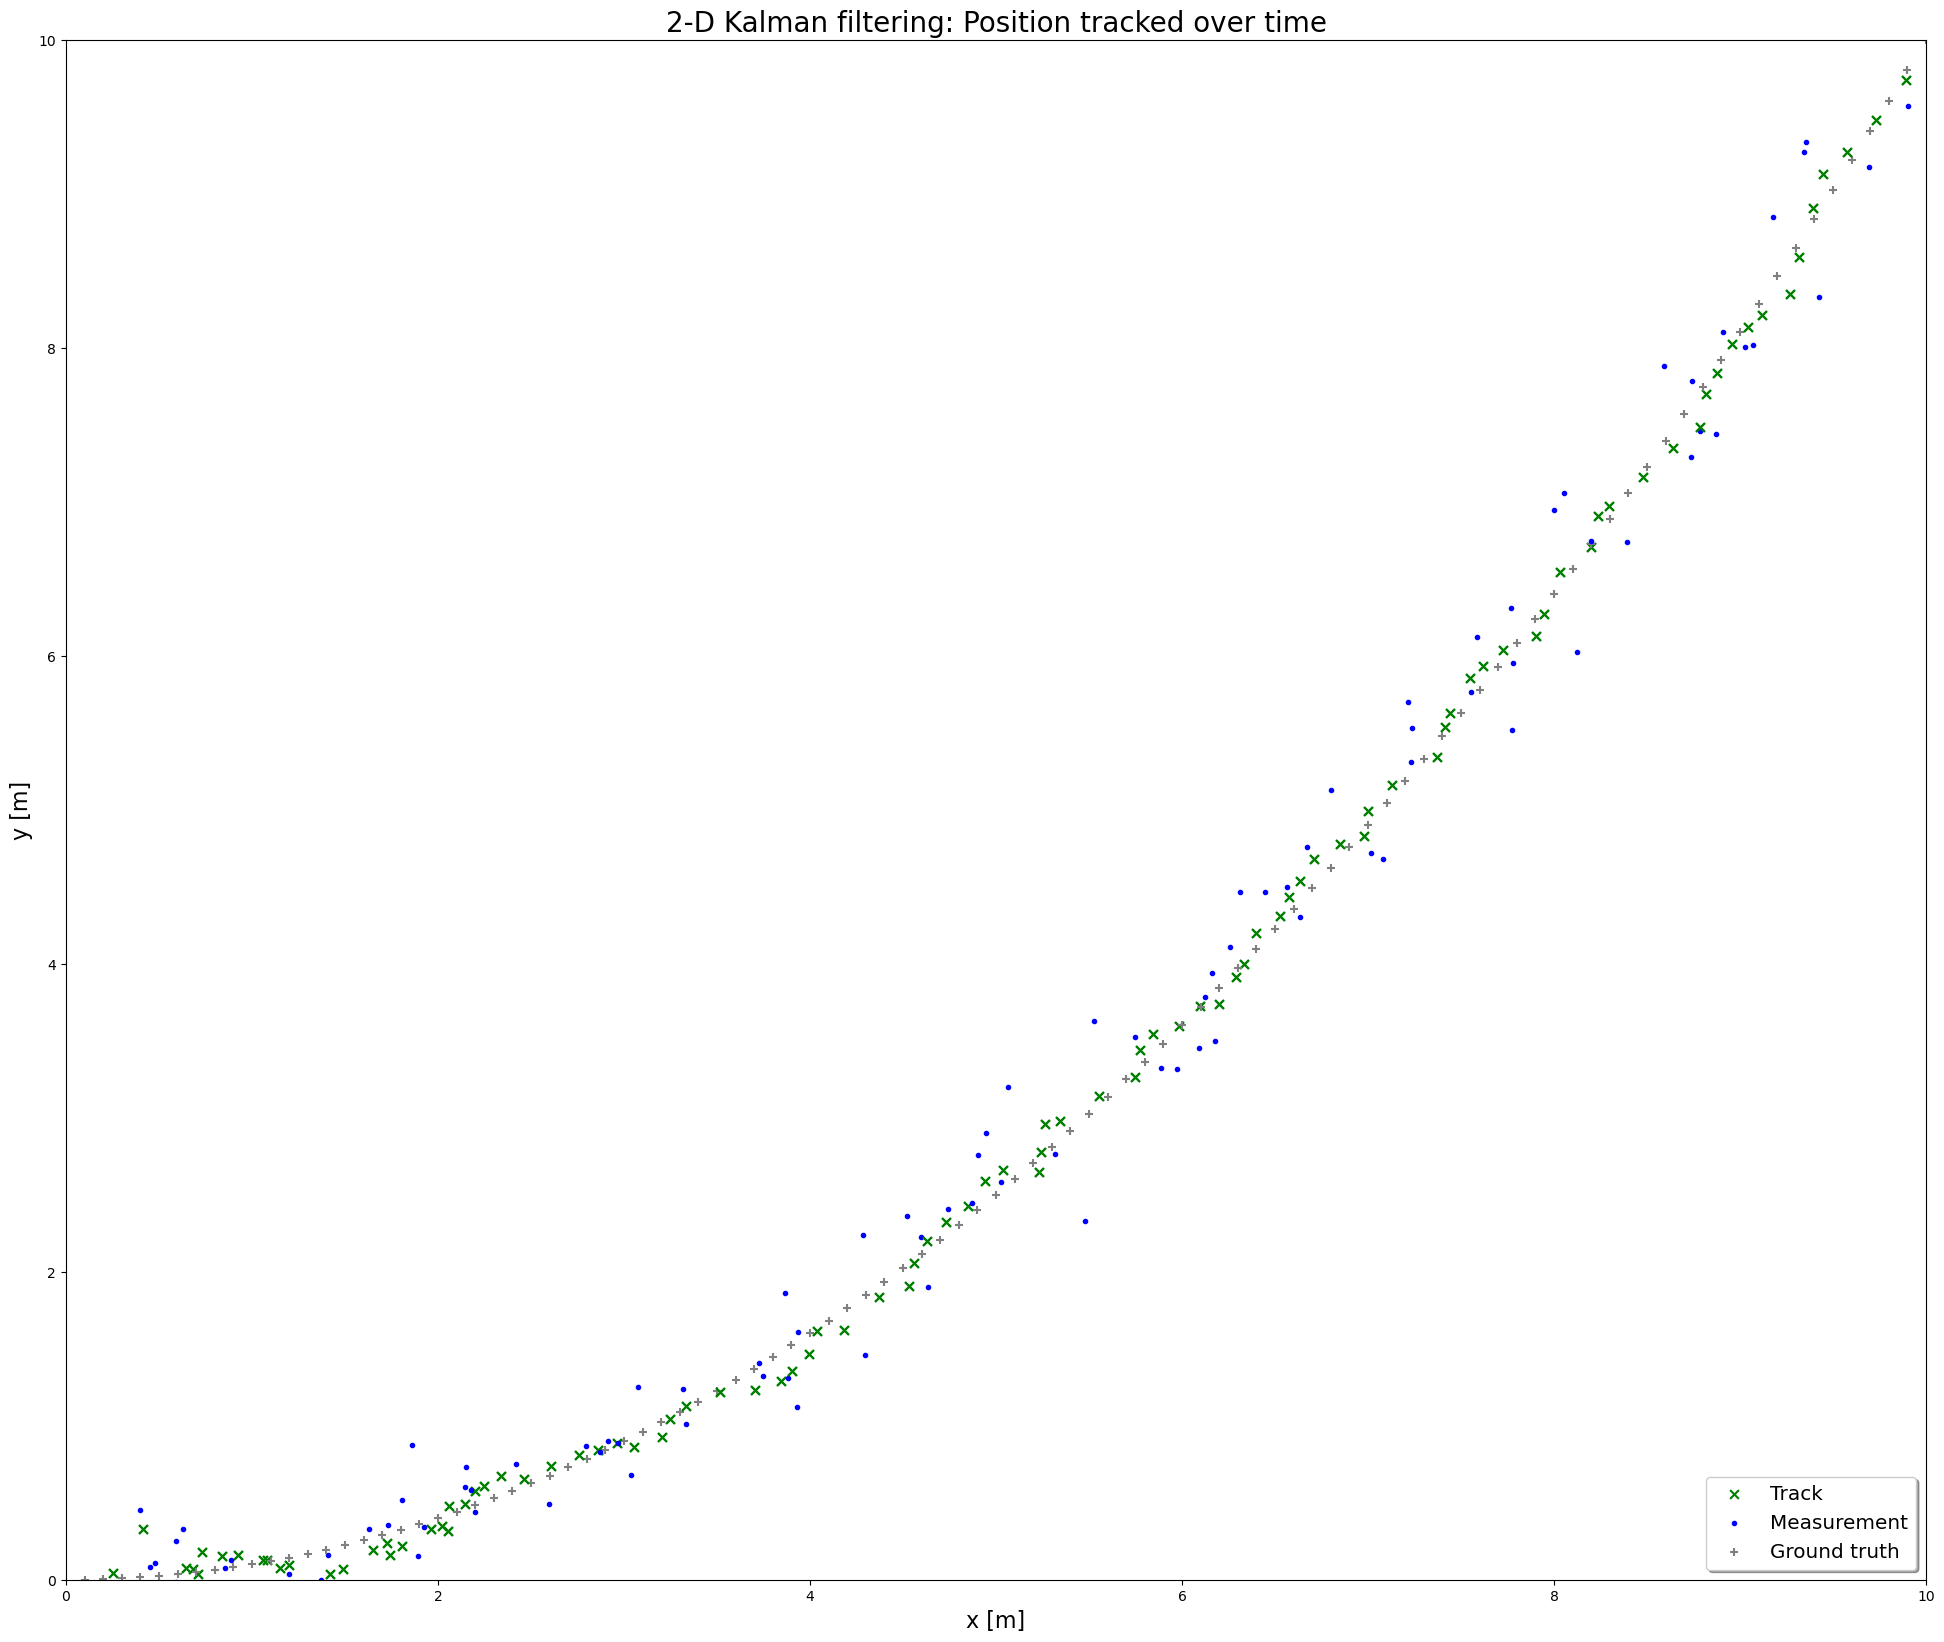

In [35]:
### Run the main loop
run_filter()

### 2.2. The Camera Sensor

In this implementation of the Extended Kalman Filter (EKF) we define the non-linear camera measurement function $h\left(\mathrm{x}\right)$ to be a Jacobian $\mathrm{H}_{J}$ computed for the current input state $\mathrm{x}$.

The linearised measurement and state transition functions $h\left(\mathrm{x}\right) \approx \mathrm{H}$ and  $f\left(\mathrm{x}\right) \approx \mathrm{F}$ are defined with respect to the parameter $\Delta{t}$. Here $\mathrm{H}$ is referred to as the projection matrix from 4D state vector $\mathrm{x}$ (ignoring the velocity components) to 2D camera sensor measurement space. This matrix is defined with respect to the camera intrinsic parameters for focal length, $f = \left(f_{i}, f_{j}\right)$, and principal point, $c = \left(C_{i}, c_{j}\right)$. The following implementation should compute and return the $2x6$ Jacobian of this matrix.

As a visual confirmation, this programme should plot the linear approximation $h\left(\mathrm{x}\right) \approx h\left(\mu\right) + \mathrm{H}_{J}\left(\mu\right)\left(x - \mu\right)$ tangent to the non-linear function $h\left(\mathrm{x}\right)$ at the given extension point $\mu = \mathrm{x}$ (shown as green 'x' in the resulting plot at the end of this section).

#### 2.2.1. The linearised `Camera` measurement model 

In [36]:
##### From J. Moran's `3_measurements.py`
# Credit: https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/main/2-Sensor-Fusion/Exercises/2-3-Extended-Kalman-Filters/exercises/3_measurements.py

In [37]:
class Camera:
    '''The Camera sensor class with non-linear measurement matrix.

    :param f_i: the focal length along the i-axis of the image plane.
    :param f_j: the focal length along the j-axis of the image plane.
    :param c_i: the component of the principal point along the i-axis.
    :param c_j: the component of the principal point along the j-axis.
    :param hx: the non-linear camera measurement function.
    :param H: the linearised camera measurement matrix as a Jacobian.
    '''

    def __init__(self):
        """Initialises the Camera object with given intrinsics."""

        # The focal length along the i-axis
        self.f_i = 2095.5
        # The focal length along the j-axis
        self.f_j = 2095.5
        # The principal point along the i-axis
        self.c_i = 944.9
        # The principal point along the j-axis
        self.c_j = 640.2
        # The non-linear camera measurement function
        self.hx = None
        # The linearised camera measurement matrix as a Jacobian
        self.H = None
        
    def get_hx(self,
            x: np.ndarray
    ) -> np.ndarray:
        """Implements the non-linear measurement function.

        :param x: the expansion point used in the first-order Taylor series.
        :returns: hx, the non-linear measurement function,
            i.e., the expectation value $h(x)$.
        """

        ### Calculate the non-linear measurement expectation value $h(x)$
        # Obtain the position coordinates from the state vector `x`
        p_x, p_y, p_z = x[0:3]
        with warnings.catch_warnings():
            # Catch any divide-by-zero warnings
            warnings.simplefilter('error')
            # Define the non-zero entries of the expectation value
            h11 = self.c_i - self.f_i * p_y / p_x
            h21 = self.c_j - self.f_j * p_z / p_x
            # Set the non-zero entries with the computed values
            hx = np.array([[h11],
                           [h21]])
            # Update the class attribute and return the expectation value vector
            self.hx = hx
        return hx
    
    def get_h(self,
            x: np.ndarray
    ) -> np.ndarray:
        """Implements the Jacobian matrix of the camera measurement function.

        Assumed is the zero contribution of the velocity term of the state
        vector in the measurement function. Here the first-order Taylor expansion
        is commputed to linearise the camera measurement function at the expansion
        point $x$.

        :param x: the expansion point used in the first-order Taylor series.
        :returns: H, the Jacobian matrix of the camera measurement function,
            i.e., $\mathrm{H}_{j}$ linearised about expansion point $x$.
        """

        ### Calculate the Jacobian `H` at current `x` of $h(x)$
        # Obtain the position coordinates from the state vector `x`
        p_x, p_y, p_z = x[0:3]
        # Define the non-zero entries of the Jacobian `H`
        # Variable naming convention is matrix [row, col] indexing starting at 1
        with warnings.catch_warnings():
            # Catch any divide-by-zero warnings
            warnings.simplefilter('error')
            h11 = self.f_i * p_y / p_x**2
            h12 = -1 * self.f_i / p_x
            h21 = self.f_j * p_z / p_x**2
            h23 = -1 * self.f_j / p_x
        # Set the non-zero entries with the computed values
        H = np.array([[h11, h12, 0., 0., 0., 0.],
                      [h21, 0., h23, 0., 0., 0.]])
        # Update the class attribute and return the Jacobian `H`
        self.H = H
        return H

##### Testing the linearised `Camera` measurement model 

In [38]:
### From J. Moran's `3_measurements.py`
# Credit: https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/main/2-Sensor-Fusion/Exercises/2-3-Extended-Kalman-Filters/exercises/3_measurements.py

In [39]:
 def calc_jacobian(
        x: np.ndarray
):
    """Linearises the camera measurement function and plots the results.
    
    Assumed is a non-linear camera measurement function resulting from the
    projection of the 6-D state vector into the 2-D image space.

    Therefore, we compute a $2x6$ Jacobian $\mathrm{H}_{j}$, i.e.,
    the linearised camera measurement model approximated with a
    first-order Taylor expansion about the expansion point $x$.

    :param x: the expansion point used in the first-order Taylor series.
    """

    ### Calculate the Jacobian for state vector `x`
    cam = Camera()
    H = cam.get_h(x)
    ### Visualise the results
    # Define the Matplotlib figure instance and data arrays
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 20),
                        constrained_layout=True)
    fig.suptitle('Linear approximation of the camera measurement function',
                        fontsize=20
    )
    ### Calculate the expansion point `x` for the first-order Taylor series
    hx_orig = cam.get_hx(x)
    # Plot the expansion point coordinates
    ax1.plot(x[0], hx_orig[0],
                        marker='x', color='green', label='Expansion point $x$'
    )
    ax2.plot(x[0], hx_orig[1],
                        marker='x', color='green', label='Expansion point $x$'
    )
    ### Calculate the linear approximation at this point
    # Define the slope of the tangent given by the Jacobian `H`
    s1 = float(H[0, 0])
    s2 = float(H[1, 0])
    # Define the intercept of the slope to be $i = y - s * x$
    i1 = float(hx_orig[0] - s1 * x[0])
    i2 = float(hx_orig[1] - s2 * x[0])
    # Calculate the non-linear measurement function $h(x)$ for each point in `x`
    plot_x = []
    plot_y1 = []
    plot_y2 = []
    lin_y1 = []
    lin_y2 = []
    for px in range(1, 50):
        # Get the expansion point for position `px`
        x[0] = px
        hx = cam.get_hx(x)
        # Append the results for plotting
        plot_x.append(px)
        plot_y1.append(hx[0])
        plot_y2.append(hx[1])
        lin_y1.append(s1 * px + i1)
        lin_y2.append(s2 * px + i2)
    ### Plot the results obtained from the linearisation of $h(x)$
    plot_x, plot_y1 = np.asarray(plot_x), np.asarray(plot_y1).squeeze()
    ax1.plot(plot_x.tolist(), plot_y1.tolist(),
                        color='blue', label='Measurement function $h(x)$'
    )
    lin_y1 = np.asarray(lin_y1).squeeze()
    ax1.plot(plot_x.tolist(), lin_y1.tolist(),
                        color='red', label='Linear approximation $\mathrm{H}$'
    )
    plot_y2 = np.asarray(plot_y2).squeeze()
    ax2.plot(plot_x.tolist(), plot_y2.tolist(),
                        color='blue', label='Measurement function $h(x)$'
    )
    lin_y2 = np.asarray(lin_y2).squeeze()
    ax2.plot(plot_x.tolist(), lin_y2.tolist(),
                        color='red', label='Linear approximation $\mathrm{H}$'
    )
    # Maximise the figure window
    if matplotlib.rcParams['backend'] == 'wxagg':
        mng = plt.get_current_fig_manager()
        mng.frame.Maximize(True)
    # Display the plot legends and set axes labels
    ax1.legend(loc='center left',
                        shadow=True, fontsize='large', bbox_to_anchor=(0.7, 0.5)
    )
    ax1.set_xlabel('x [m]', fontsize=16)
    ax1.set_ylabel('First component of $h(x)$ [px]', fontsize=18)
    ax2.legend(loc='center left',
                        shadow=True, fontsize='large', bbox_to_anchor=(0.7, 0.5)
    )
    ax2.set_xlabel('x [m]', fontsize=16)
    ax2.set_ylabel('Second component of $h(x)$ [px]', fontsize=18)
    # Show the Matplotlib figure
    plt.show()

In [40]:
### Init the camera measurement model and compute its linear approximation

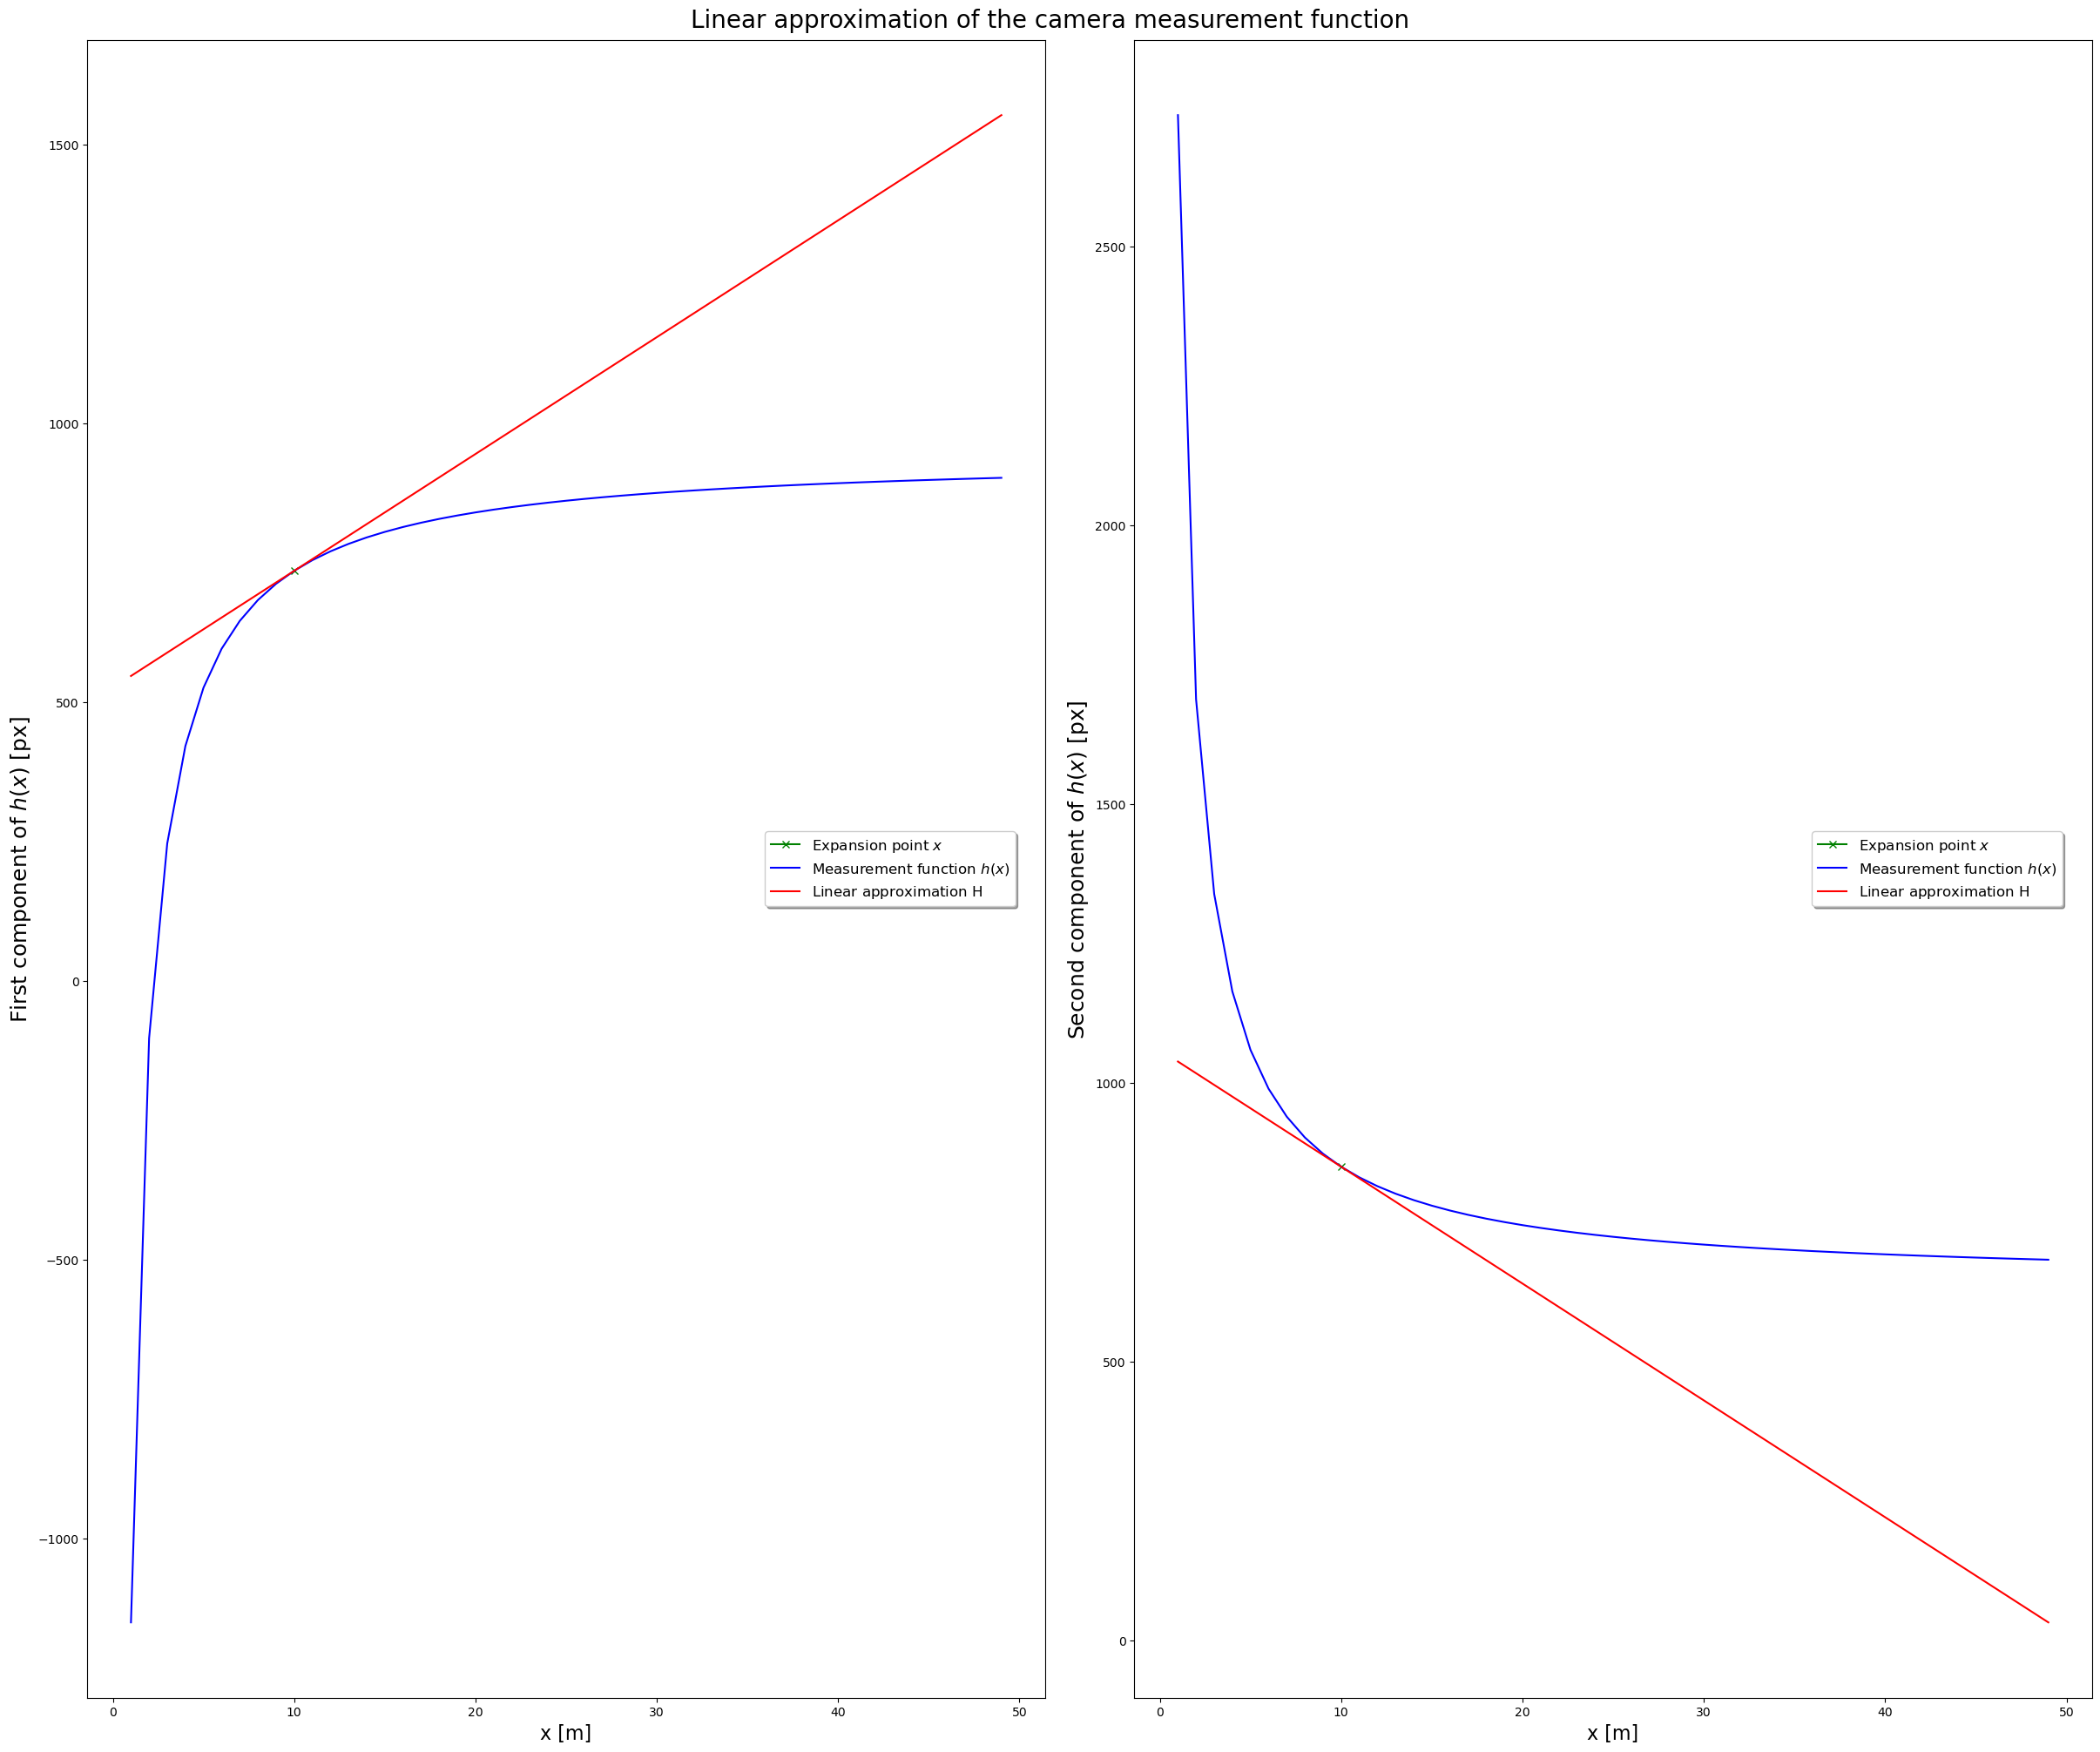

In [41]:
# Here we define the expansion point of the Taylor series
x = np.array([[10],
              [1],
              [-1],
              [0],
              [0],
              [0]]
)
# Run the linearisation programme and plot the results
calc_jacobian(x)

Here we see the linearised function $h\left(\mathrm{x}\right) \approx h\left(\mu\right) + \mathrm{H}_{J}\left(\mu\right)\left(\mathrm{x} - \mu\right)$ closely approximates the non-linear camera measurement function $h\left(\mathrm{x}\right)$ at the expansion point $\mu = \left[10, 1, -1\right]^{\top}$.

Congratulations! If you've followed the code up to this point, you have everything you need to get started on your very own implementation of an Extended Kalman Filter (EKF) with sensor fusion of both LiDAR and camera sensor measurements. Exciting, isn't it? I think so!

## 3. Closing Remarks

##### Alternatives
* Work out the derivations of the Jacobian $\mathrm{H}_{J}$, i.e., the partial derivatives of the measurement function $h\left(\mathrm{x}\right)$;
* Derive the Jacobian $\mathrm{F}_{J}$ of a non-linear state transition function $f\left(\mathrm{x}\right)$.

##### Extensions of task
* Extend the object motion model beyond a constant velocity assumption.

## 4. Future Work

- ⬜️ Implement Extended Kalman Filter (EKF) tracking with sensor fusion alongside the 3D object detection pipeline from [Project 2.1](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/tree/2-1-3D-Object-Detection/2-Sensor-Fusion/2-1-3D-Object-Detection-with-LiDAR-Data).

## Credits

This assignment was prepared by Dr. Andreas Haja and Dr. Antje Muntzinger et al., 2021 (link [here](https://github.com/udacity/nd013-c2-fusion-starter)).


References
* [1] Kalman, R. E. A New Approach to Linear Filtering and Prediction Problems. Journal of Basic Engineering. American Society of Mechanical Engineers. 82(1):35-45. 1960. [doi:10.1115/1.3662552](https://doi.org/10.1115/1.3662552).

Helpful resources:
* [Tutorial: The Kalman Filter by T. Lacey | MIT](http://web.mit.edu/kirtley/kirtley/binlustuff/literature/control/Kalman%20filter.pdf);
* [ND0013 C2 L5 Lectures by Dr. Antje Muntzinger | YouTube](https://www.youtube.com/playlist?list=PL6nu8g-5OMNgl_rtYmrGa-K4lkjcTJbL5).